In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import pickle
import tensorflow as tf

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
# NUM_CLASSES = 50 # limit classes trained

from collections import defaultdict
from scipy.misc import imread, imresize
from numpy.random import choice

# used to help generate training, testing, and validation datasets by randomly sampling all data.
class Datasets(object):
    def __init__(self, ratio, subdir="default", num_classes=50, load_new_data=True):
        """
        Ratio: [training, validation, testing] ratios.
        load_new_data: whether or not to create new train/val/test datasets from scratch
        """
        self.sets = {}
        self.ordered_keys = ['train', 'val', 'test']
        self.num_classes = num_classes
        self.meta = pickle.load(open('metadata', 'rb'))

        for set_key in ['train', 'val', 'test']:
            self.sets[set_key] = {}
            self.sets[set_key]['imgs'] = []
            self.sets[set_key]['lbls'] = []
            self.sets[set_key]['addrs'] = []

        if load_new_data:
            all_instances = self.load_all_instances()
            self.spread_data(ratio, all_instances)
            self.save_addrs(subdir)
        else:
            self.load_from_addrs(subdir)
    
    def load_single_img(self, bb_coords, im_addr):
        """
        bb_coords = takes string values for x, y, width, and height of bounding box.
        im_addr = filepath of the image relative to CUB_200_2011/images/
        """
        img = imread('CUB_200_2011/images/' + im_addr)

        bb_x, bb_y, bb_w, bb_h = [int(x) for x in bb_coords]
        if len(img.shape) == 2:
            img = np.dstack([img, img, img])
        if 0 in img.shape:
            raise

        img = img[bb_y:bb_y + bb_h, bb_x:bb_x + bb_w, :]
        img = imresize(img, (224, 224))
        
        return img
    
    def load_all_instances(self):
        """
        Loads in all images and their classes, before creating train/val/test datasets with them.
        Returns: {class_id -> [all instances of this class, as processed images]}
        """
        class_ids = set()

        ALL_INSTANCES = defaultdict(list) # maps class id to list of images in that class.

        for index, row in self.meta.iterrows():
            im_id, im_addr, bb_x, bb_y, bb_w, bb_h, class_id = row

            if class_id not in class_ids:
                if len(class_ids) >= self.num_classes:
                    break
                class_ids.add(class_id)
            
            try:
                img = self.load_single_img([bb_x, bb_y, bb_w, bb_h], im_addr)
            except:
                continue

            ALL_INSTANCES[class_id] += [(img, im_addr)]
        
        return dict(ALL_INSTANCES)
    
    def save_addrs(self, subdir):
        """
        Only run for the case of creating new train/val/test datasets: saves addresses/classes to file, so that
        clearing output and restarting will not change the dataset makeup.
        """
        for set_type in self.ordered_keys:
            with open('./dataset_reconstruct/' + subdir + '/' + set_type + '.txt', 'w') as outf:
                for lbl, addr in zip(self.sets[set_type]['lbls'], self.sets[set_type]['addrs']):
#                     print(set_type, lbl, addr)
                    outf.write(lbl.astype(str) + ' ' + addr.astype(str) + '\n')
    
    def load_from_addrs(self, subdir):
        """
        subdir = subdirectory under `dataset_reconstruct`
        Loads dataset from lists of image addresses: {train, val, test}.txt
        """
#         import pdb; pdb.set_trace()
        for set_type in self.ordered_keys:
            with open('./dataset_reconstruct/' + subdir + '/' + set_type + '.txt', 'r') as inf:
                for line in inf:
                    class_id, im_addr = line.split()
                    for row in self.meta.loc[self.meta['image_addr'] == im_addr].iterrows():
                        _, _, bb_x, bb_y, bb_w, bb_h, _ = row[1]
                    
                    try:
                        img = self.load_single_img([bb_x, bb_y, bb_w, bb_h], im_addr)
                    except:
                        continue

                    self.sets[set_type]['imgs'].append(img)
                    self.sets[set_type]['lbls'].append(class_id)

            self.sets[set_type]['imgs'] = np.array(self.sets[set_type]['imgs'])
            self.sets[set_type]['lbls'] = np.array(self.sets[set_type]['lbls'])

    def spread_data(self, ratio, all_instances):
        """
        Forms training, validation, and testing set by random sampling
        """
        for class_id, imgs in all_instances.items():
        # distributes samples evenly from each class, to balance out train/test/validation sets.
            train_s, train_e = 0, round(ratio[0] * len(imgs))
            val_s, val_e = round(ratio[0] * len(imgs)) + 1, round((ratio[0] + ratio[1]) * len(imgs))
            test_s, test_e = round((ratio[0] + ratio[1]) * len(imgs) + 1), len(imgs)
            partitioned_imgs = [imgs[train_s:train_e], imgs[val_s:val_e], imgs[test_s:test_e]]
            
            for idx, partition in enumerate(partitioned_imgs):
                for img, img_addr in partition:
#                     set_choice_idx = choice([0, 1, 2], p=ratio)
                    set_type = self.ordered_keys[idx]
                    self.sets[set_type]['imgs'].append(img)
                    self.sets[set_type]['lbls'].append(class_id)
                    self.sets[set_type]['addrs'].append(img_addr)
        for set_type in self.ordered_keys:
            self.sets[set_type]['imgs'] = np.array(self.sets[set_type]['imgs'])
            self.sets[set_type]['lbls'] = np.array(self.sets[set_type]['lbls'])
            self.sets[set_type]['addrs'] = np.array(self.sets[set_type]['addrs'])

    def show_dataset_size(self):
        """
        Print length of training, validation, and testing set
        """
        print('Train set size:', self.sets['train']['imgs'].shape)
        print('Validation set size:', self.sets['val']['imgs'].shape)
        print('Test set size:', self.sets['test']['imgs'].shape)

train_test_ratio = [0.5, 0.25, 0.25]

datasets = Datasets(train_test_ratio)
datasets.show_dataset_size()

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel_launcher.py:37: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel_launcher.py:46: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


Train set size: (1447, 224, 224, 3)
Validation set size: (670, 224, 224, 3)
Test set size: (675, 224, 224, 3)


In [3]:
# save dataset (train, validation, test) from im_addrs stored

# datasets = Datasets(train_test_ratio, load_new_data=False)
# datasets.show_dataset_size()

In [4]:
import vgg as vgg_mod
import importlib
importlib.reload(vgg_mod)

sess = tf.Session()

vgg_obj = None

imgs = tf.placeholder(tf.float32, [None, 224, 224, 3])
vgg_obj = vgg_mod.vgg16(imgs, 'vgg16_weights.npz', sess)

labels_ph = tf.placeholder(tf.int64, (None), name='labels_ph')
labels_ph_oh = tf.one_hot(labels_ph, 50)

# Get trainable variables for the last three custom FC layers (featuring dropout, etc)
fc_stem = 'fully_connected'
trainable_vars_list = []
for i in ['', '_1', '_2']:
    trainable_weight_var = tf.contrib.framework.get_variables(fc_stem + i + '/weights:0')
    trainable_bias_var = tf.contrib.framework.get_variables(fc_stem + i + '/biases:0')
    trainable_vars_list += [trainable_weight_var, trainable_bias_var]

optimizer_warm = tf.train.AdamOptimizer(0.001, 0.9, 0.999)
loss_warm = tf.nn.sigmoid_cross_entropy_with_logits(logits=vgg_obj.logits, labels=labels_ph_oh)
opt_warm = optimizer_warm.minimize(loss_warm, var_list=trainable_vars_list)

optimizer_full = tf.train.AdamOptimizer(0.00001, 0.9, 0.999)
loss_full = tf.nn.sigmoid_cross_entropy_with_logits(logits=vgg_obj.logits, labels=labels_ph_oh)
opt_full = optimizer_full.minimize(loss_full)

correct = tf.equal(tf.argmax(vgg_obj.logits, 1), labels_ph)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

sess.run(tf.global_variables_initializer())
vgg_obj.load_weights(vgg_obj.weights, vgg_obj.sess)

0 conv1_1_W (3, 3, 3, 64)
1 conv1_1_b (64,)
2 conv1_2_W (3, 3, 64, 64)
3 conv1_2_b (64,)
4 conv2_1_W (3, 3, 64, 128)
5 conv2_1_b (128,)
6 conv2_2_W (3, 3, 128, 128)
7 conv2_2_b (128,)
8 conv3_1_W (3, 3, 128, 256)
9 conv3_1_b (256,)
10 conv3_2_W (3, 3, 256, 256)
11 conv3_2_b (256,)
12 conv3_3_W (3, 3, 256, 256)
13 conv3_3_b (256,)
14 conv4_1_W (3, 3, 256, 512)
15 conv4_1_b (512,)
16 conv4_2_W (3, 3, 512, 512)
17 conv4_2_b (512,)
18 conv4_3_W (3, 3, 512, 512)
19 conv4_3_b (512,)
20 conv5_1_W (3, 3, 512, 512)
21 conv5_1_b (512,)
22 conv5_2_W (3, 3, 512, 512)
23 conv5_2_b (512,)
24 conv5_3_W (3, 3, 512, 512)
25 conv5_3_b (512,)


In [5]:
# Training code
BS = 64
NUM_EPOCHS_WARM = 15
NUM_EPOCHS_FULL = 8

train_imgs = datasets.sets['train']['imgs']
train_lbls = datasets.sets['train']['lbls']

val_imgs = datasets.sets['val']['imgs']
val_lbls = datasets.sets['val']['lbls']

training = vgg_obj.training
keep_prob = vgg_obj.keep_prob

mean_train_accs, mean_losses, mean_val_accs = [], [], []

def train_for_epochs(optimizer_in, loss_in, epochs, correct_in, accuracy_in):
    for epoch in range(epochs):
        # Let's shuffle the data every epoch
        np.random.seed(epoch)
        np.random.shuffle(train_imgs)
        np.random.seed(epoch)
        np.random.shuffle(train_lbls)
        # Go through the entire dataset once
        accuracy_vals, loss_vals, val_correct = [], [], []
        for i in range(0, train_imgs.shape[0]-BS+1, BS):
            # Train a single batch
            batch_images, batch_labels = train_imgs[i:i+BS], train_lbls[i:i+BS]
            accuracy_val, loss_val, _ = sess.run([accuracy_in, loss_in, optimizer_in], feed_dict={imgs: batch_images, labels_ph: batch_labels, training: True, keep_prob: 0.9})
            accuracy_vals.append(accuracy_val)
            loss_vals.append(loss_val)

        for i in range(0, val_imgs.shape[0], BS):
            batch_images, batch_labels = val_imgs[i:i+BS], val_lbls[i:i+BS]
            val_correct.extend( sess.run(correct_in, feed_dict={imgs: batch_images, labels_ph: batch_labels, training: False, keep_prob:0.9}) )
        
        mean_train_acc, mean_loss, mean_val_acc = np.mean(accuracy_vals), np.mean(loss_vals), np.mean(val_correct)
        mean_train_accs.append(mean_train_acc)
        mean_losses.append(mean_loss)
        mean_val_accs.append(mean_val_acc)
        print('[%3d] Accuracy: %0.3f  \t  Loss: %0.3f \t Val acc: %0.3f'%(epoch, mean_train_acc, mean_loss, mean_val_acc))
train_for_epochs(opt_warm, loss_warm, NUM_EPOCHS_WARM, correct, accuracy)
train_for_epochs(opt_full, loss_full, NUM_EPOCHS_FULL, correct, accuracy)

[  0] Accuracy: 0.192  	  Loss: 0.770 	 Val acc: 0.106
[  1] Accuracy: 0.486  	  Loss: 0.728 	 Val acc: 0.248
[  2] Accuracy: 0.621  	  Loss: 0.710 	 Val acc: 0.282
[  3] Accuracy: 0.685  	  Loss: 0.696 	 Val acc: 0.421
[  4] Accuracy: 0.744  	  Loss: 0.687 	 Val acc: 0.364
[  5] Accuracy: 0.752  	  Loss: 0.683 	 Val acc: 0.384
[  6] Accuracy: 0.771  	  Loss: 0.677 	 Val acc: 0.355
[  7] Accuracy: 0.763  	  Loss: 0.679 	 Val acc: 0.349
[  8] Accuracy: 0.792  	  Loss: 0.673 	 Val acc: 0.399
[  9] Accuracy: 0.793  	  Loss: 0.669 	 Val acc: 0.434
[ 10] Accuracy: 0.801  	  Loss: 0.668 	 Val acc: 0.372
[ 11] Accuracy: 0.781  	  Loss: 0.668 	 Val acc: 0.437
[ 12] Accuracy: 0.790  	  Loss: 0.668 	 Val acc: 0.475
[ 13] Accuracy: 0.773  	  Loss: 0.669 	 Val acc: 0.531
[ 14] Accuracy: 0.790  	  Loss: 0.667 	 Val acc: 0.497
[  0] Accuracy: 0.783  	  Loss: 0.668 	 Val acc: 0.531
[  1] Accuracy: 0.787  	  Loss: 0.666 	 Val acc: 0.528
[  2] Accuracy: 0.800  	  Loss: 0.663 	 Val acc: 0.546
[  3] Accu

## notes about running hyperparameters:

1. Warmup starts to overfit after ~15 epochs. So use 12 instead, and hopefully the full network training will improve generalization.

In [7]:
test_imgs_processed = datasets.sets['test']['imgs']
test_labels = datasets.sets['test']['lbls']
print(test_imgs_processed.shape)

num_test = len(test_imgs_processed)
test_batch_size = 128
total_top_1, total_top_3, total_top_5 = [[] for x in range(3)]

for batch_start in range(0, num_test - test_batch_size + 1, test_batch_size):
    
    img_batch = test_imgs_processed[batch_start:batch_start + test_batch_size, :, :, :]
#     print(img_batch.shape)
    labels_batch = test_labels[batch_start:batch_start + test_batch_size]
    test_probabilities = sess.run(vgg_obj.probs, feed_dict={vgg_obj.imgs: img_batch, training: False, keep_prob:0.9})

    top_1_correct, top_3_correct, top_5_correct = [0] * 3
    for sample_idx, sample in enumerate(test_probabilities):
        top_predictions = (np.argsort(sample)[::-1])[:5]
        test_label = labels_batch[sample_idx]
        if test_label in top_predictions[:1]:
            top_1_correct += 1
        if test_label in top_predictions[:3]:
            top_3_correct += 1
        if test_label in top_predictions:
            top_5_correct += 1
        
#     print(top_5_correct)

    total_top_1.append(top_1_correct)
    total_top_3.append(top_3_correct)
    total_top_5.append(top_5_correct)

print('Test accuracy:')
print('Top-1:', np.mean(total_top_1))
print('Top-3:', np.mean(total_top_3))
print('Top-5:', np.mean(total_top_5))
testaccs = [total_top_1, total_top_3, total_top_5]

(675, 224, 224, 3)
Test accuracy:
Top-1: 77.6
Top-3: 87.8
Top-5: 89.8


In [10]:
saver = tf.train.Saver(tf.trainable_variables())
saver.save(sess, './checkpoints/bird_573_val_acc.ckpt')

'./checkpoints/bird_573_val_acc.ckpt'

In [9]:
# stem is file stem, the next three are arrays, and the last is an array of [top 1, top 3, top 5] accuracies.
def save_train_acc_loss(stem, trainaccs, losses, valaccs, testaccs):
    np.save('./run_results/' + stem + '_accuracy_progress', np.stack([trainaccs, losses, valaccs]))
    np.save('./run_results/' + stem + '_test_accs', testaccs)
save_train_acc_loss('776testacc', mean_train_accs, mean_losses, mean_val_accs, testaccs)

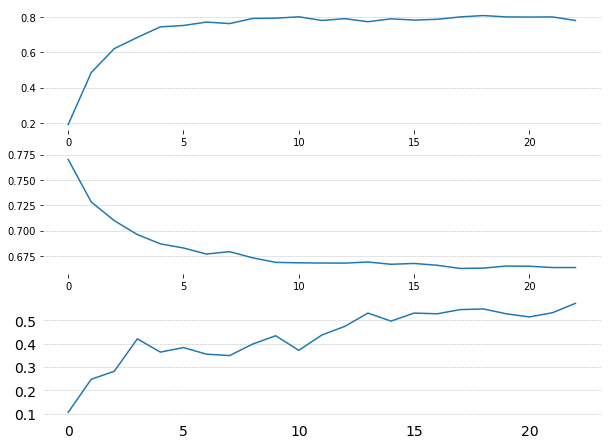

In [79]:
%matplotlib inline

stems = ['776testacc']

color_sequence = ['#1f77b4', '#aec7e8', '#ff7f0e', '#ffbb78', '#2ca02c',
                  '#98df8a', '#d62728', '#ff9896', '#9467bd', '#c5b0d5',
                  '#8c564b', '#c49c94', '#e377c2', '#f7b6d2', '#7f7f7f',
                  '#c7c7c7', '#bcbd22', '#dbdb8d', '#17becf', '#9edae5']

fig, axs = plt.subplots(3, 1, figsize=(10, 7.5))

for ax in axs:
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)

    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()

    ax.xaxis.set_major_formatter(plt.FuncFormatter('{:.0f}'.format))
    # ax.yaxis.set_major_formatter(plt.FuncFormatter('{:.0f}'.format))
    ax.grid(True, 'major', 'y', ls='--', lw=.5, c='k', alpha=.3)


# axs[0].set_ylim(0, 0.803)
# axs[0].set_xlim(0, 23)

plt.xticks(range(0, 40, 5), fontsize=14)
plt.yticks(np.arange(0, 1, 0.1), fontsize=14)


plt.tick_params(axis='both', which='both', bottom='off', top='off',
                labelbottom='on', left='off', right='off', labelleft='on')

for stem_idx, stem in enumerate(stems):
    a_train_accs, a_losses, a_val_accs = np.load('./run_results/' + stem + '_accuracy_progress.npy')
    axs[0].plot(range(0, 23), a_train_accs, lw=1.5, color=color_sequence[stem_idx])
    axs[1].plot(range(0, 23), a_losses, lw=1.5, color=color_sequence[stem_idx])
    axs[2].plot(range(0, 23), a_val_accs, lw=1.5, color=color_sequence[stem_idx])
#     for epoch, val in enumerate(zip(a_train_accs, a_losses, a_val_accs)):
#         t, l, v = val
#         line = ax.plot(epoch, t, lw=100, color=color_sequence[stem_idx])
#         axs[1].plot(epoch, l, lw=2.5, color=color_sequence[stem_idx])
#         axs[2].plot(epoch, v, lw=2.5, color=color_sequence[stem_idx])

plt.show()